# Adversial Learning Implementation on MNIST

**Credit:** This project is written by Y. Qiu

## 1. MNIST Classifier Utilizing CNN
### 1.1 Hyperparameters
The following block shows the hyperparameters of the CNN model.  
1. `learning_rate` indicates learning rate.  
2. `batch_size_train` indicates the size of batch of the training dataset since batch processing is introduced to speed up the process.  
3. `batch_size_test` indicates the size of batch of the testing dataset since batch processing is introduced to speed up the process. 
4. `drop_out_rate` indicates the probability at which neurons are dropped out.
5. `normalize`,`normalize_mean` and `normalize_std` are three hyperparameters controlling normalization of data preprocessing. `normalize` indicates whether normalize the original data in data preprocessing. When `normalize=True`, apply normalization to the original dataset using the following `normalize_mean` and `normalize_std`, the specific meaning of which will be discussed in **1.3**.  \
   Note that `normalize_mean` and `normalize_std` must be tuples.  
6. `optimizer_choice` indicates the choice of optimizer used to optimize the parameters in the network.
7. `log_interval` indicates the number of training examples in the interval when logging out the current loss when training.   
8. `n_epochs` indicates the number of training epoches.  
9. `activation` indicates the activation function used in CNN.  
10. `loss_func` indicates the loss function.  
11. `loss_func_test` indicates the loss function **without built-in average treatment**, since in the test process we need to accumulate the loss in every batch.  
12. `random_seed` indicates the random seed used for repeatable experiments.

In [2]:
learning_rate = 0.005
batch_size_train = 64
batch_size_test = 1000
drop_out_rate = 0.5

normalize = True
normalize_mean = (0.1307,)
normalize_std = (0.3081,)
                            # those figures are given in the pytorch official website

from torch.optim import Adam, SGD
optimizer_choice = Adam

log_interval = 100
n_epochs = 3

from torch.nn import LeakyReLU, CrossEntropyLoss as CEL
activation = LeakyReLU(inplace=True)
loss_func = CEL()
loss_func_test = CEL(reduction='sum')

random_seed = 1

### 1.2 Necessary Packages
The following block imports several needed packages, mostly packed in **pyTorch**, **Matplotlib**, **Numpy** and **OpenCV.**  
- Details are given in the annotation.

In [3]:
import torch                                            # necessary in constructing the network.
import torchvision                                      # used to download and preprocess the MNIST dataset.
from torch.utils.data import DataLoader                 # same as above
import torchvision.transforms as tsf                    # same as above, used in data preprocessing.
import torch.nn as nn                                   # necessary in constructing the network.
import torch.nn.functional as func                      # same as above, providing useful functions.
import matplotlib.pyplot as plt                         # used in creating figures and visualizations
from PIL import Image                                   # used in testing local pictures
import numpy as np                                      # used in some mathemetical operations
import time                                             # used for timer

torch.manual_seed(random_seed)

pass

### 1.3 Data Preparation
Data preparation includes two steps: data download and data preprocessing.
- Download MNIST dataset using built-in methods in `torchvision`.
- Preprocess original data, i.e. normalization and divide datasets into batches.  
  According to pyTorch official website,  
  
$${\rm Normalize(mean,std)}:  x=\dfrac{x_{\text{original}}-\text{mean}}{\text{std}}$$

In [4]:
trans = tsf.ToTensor()
if (normalize):
    trans = tsf.Compose([tsf.ToTensor(), tsf.Normalize(normalize_mean, normalize_std)])

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=trans),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=trans),
  batch_size=batch_size_test, shuffle=True)

E:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 1.4 Network Construction
Utilizing `torch.nn` to construct the network.  
In this project, we construct a CNN with 3 convolution layers and 3 fully connected layers.  
- Details are given in the annotations.  

The following block defines a CNN with 3 Conv layers and 3 FC layers.

In [5]:
# 3-layer version.

class CNN(nn.Module):                  # CNN with 2 Conv layers and 2 FC layers
    def __init__(self):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d( 1, 8, kernel_size=3, padding=1),              #  1*28*28 -> 8*28*28
            activation,
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),        #  8*28*28 -> 8*28*28 since 28*28 is quite a small size
            nn.Conv2d( 8,16, kernel_size=3, padding=1),              #  8*28*28 -> 16*28*28
            activation,
            nn.MaxPool2d(kernel_size=2),                             # 16*28*28 -> 16*14*14
            nn.Conv2d(16,32, kernel_size=3),                         # 16*14*14 -> 32*12*12
            activation,
            nn.MaxPool2d(kernel_size=2),                             # 32*12*12 -> 32*6*6
            nn.Flatten(1),                                           # 32*6*6   -> 1*1152, i.e. a vector
            nn.Dropout(drop_out_rate),
            nn.Linear(1152, 288),
            activation,
            nn.Dropout(drop_out_rate),
            nn.Linear( 288,  64),
            activation,
            nn.Dropout(drop_out_rate),
            nn.Linear(  64,  10)
        )       # END self.network
        
    def forward(self, x):
        return func.log_softmax(self.network(x), dim=1)                    # Using log_softmax to represent the probability of each category.

The following block prepare the optimizer.  
For further experiments, we can introduce **StepLR** to better train the model.

In [5]:
net = CNN()
optimizer = optimizer_choice(net.parameters(), lr=learning_rate)

#from torch.optim.lr_scheduler import StepLR
#step_optimizer = StepLR(optimizer,step_size=50,gamma=0.8)

Thanks to the help of ***Qi Fan***, one of my partner in the groupwork, I learned about the module "torchsummary".  
Using "summary", we can get a more visual glimpse of our network's structure.

In [6]:
from torchsummary import summary
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 29, 29]               0
            Conv2d-4           [-1, 16, 29, 29]           1,168
         LeakyReLU-5           [-1, 16, 29, 29]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 12, 12]           4,640
         LeakyReLU-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
          Dropout-11                 [-1, 1152]               0
           Linear-12                  [-1, 288]         332,064
        LeakyReLU-13                  [-1, 288]               0
          Dropout-14                  [

E:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 1.5 Model Training and Testing Preparation
Train the CNN constructed for `n_epoch` epochs and log the loss as it goes.  
Also, save the model when training.  
The following several block defines the training methods.

In [7]:
train_loss = []
train_acc = []
train_cnt = []

test_loss = []
test_acc = []
test_cnt = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
# Lists used for logging loss and accuracy in training and testing iterations.

In [8]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    correct_log = 0
    sumnum = 0
    
    global train_loss
    global train_acc
    global train_cnt
    
    for batch, (data, target) in enumerate(train_loader):
        batch_idx = batch + 1
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(1, keepdim=True)
        correct_cur = pred.eq(target.view_as(pred)).sum().item()
        correct_log += correct_cur
        
        if batch_idx % log_interval == 0:
            print('Train Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.2f}%)'.format(
                            epoch, batch_idx * len(data), len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.item(),
                            correct_log, log_interval * len(data), 100. * correct_log / (log_interval * len(data)) ))
            correct_log = 0
            sumnum += len(data) * log_interval
        
        train_loss += [loss.item()]
        train_acc += [correct_cur / len(data)]
        train_cnt += [(batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset))]
        correct_fig = 0
    
    if len(train_loader) % log_interval != 0:
        print('Train Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.2f}%)'.format(
                                epoch, batch_idx * len(data), len(train_loader.dataset),
                                100. * batch_idx / len(train_loader), loss.item(), 
                                correct_log, len(train_loader.dataset)-sumnum, 100. * correct_log / (len(train_loader.dataset)-sumnum) ))
    
    torch.save(model, 'model'+str(epoch)+'.pth')

In [9]:
def test(model, test_loader):
    model.eval()
    loss = 0
    correct = 0
    
    global test_loss
    global test_acc
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss += loss_func_test(output, target).item()
            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    loss /= len(test_loader.dataset)
    test_loss += [loss]
    test_acc += [correct / len(test_loader.dataset)]
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(loss, correct, len(test_loader.dataset),
                                                                              100. * correct / len(test_loader.dataset)))
    

### 1.6 Model Training and Testing

In [10]:
print("Before Training:", end="")
test(net, test_loader)

print("During Training:")
for epoch in range(n_epochs):
    train(net, optimizer, train_loader, epoch+1)
    test(net, test_loader)

Before Training:
Test set: Avg. loss: 2.3010, Accuracy: 1010/10000 (10.10%)

During Training:
Train Epoch 1 [6400/60000 (11%)]	Loss: 0.433254	 Accuracy: 4279/6400 (66.86%)
Train Epoch 1 [12800/60000 (21%)]	Loss: 0.431017	 Accuracy: 5731/6400 (89.55%)
Train Epoch 1 [19200/60000 (32%)]	Loss: 0.152698	 Accuracy: 5907/6400 (92.30%)
Train Epoch 1 [25600/60000 (43%)]	Loss: 0.257842	 Accuracy: 5937/6400 (92.77%)
Train Epoch 1 [32000/60000 (53%)]	Loss: 0.173656	 Accuracy: 5967/6400 (93.23%)
Train Epoch 1 [38400/60000 (64%)]	Loss: 0.503042	 Accuracy: 6039/6400 (94.36%)
Train Epoch 1 [44800/60000 (75%)]	Loss: 0.360331	 Accuracy: 6099/6400 (95.30%)
Train Epoch 1 [51200/60000 (85%)]	Loss: 0.153391	 Accuracy: 6076/6400 (94.94%)
Train Epoch 1 [57600/60000 (96%)]	Loss: 0.139074	 Accuracy: 6061/6400 (94.70%)
Train Epoch 1 [30016/60000 (100%)]	Loss: 0.477194	 Accuracy: 2271/2400 (94.62%)

Test set: Avg. loss: 0.0782, Accuracy: 9754/10000 (97.54%)

Train Epoch 2 [6400/60000 (11%)]	Loss: 0.201862	 Accura

### 1.7 Plot Depictng Loss and Accuracy Change

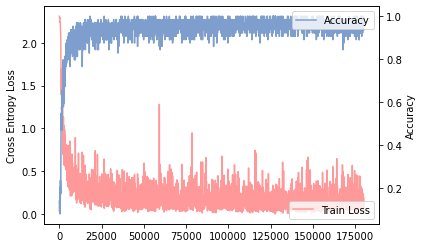

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = plt.subplot()
ax2 = ax1.twinx()

ax1.plot(train_cnt, train_loss, color='#ff9999')
#ax1.scatter(test_cnt, test_loss, color='red')
ax1.legend(['Train Loss'], loc='lower right')
ax1.set_ylabel('Cross Entropy Loss')

ax2.plot(train_cnt, train_acc, color='#7e9ecd')
ax2.legend(['Accuracy'], loc='upper right')
ax2.set_ylabel('Accuracy')

plt.xlabel('number of training examples seen')
plt.show()

### 1.8 Model Loading and Local Sample Testing
In the first following block, the former model constructed, trained, and saved will be loaded.  
In the second block, some tests from the original MNIST dataset are extracted to test the loaded model.  
In the third block, some local samples are given to test the model.

In [6]:
model = torch.load('model'+str(n_epochs)+'.pth')

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

model = model.to(device)
model.eval()

pass

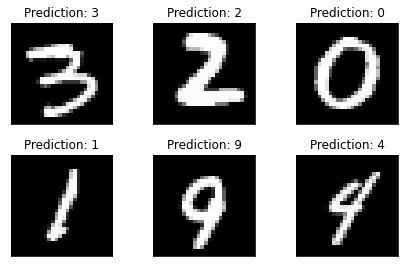

In [13]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.argmax(1, keepdim=True)[i].item()))
    plt.xticks([])
    plt.yticks([])

plt.show()

The following block loads two local test samples, which are intersting since the former one is highly likely been mistaken for $"5"$ and $"8"$ respectively by the model trained above.  
However, the first sample is designed with the purpose to see whether the model would recognize it as $"0"$ or $"6"$.

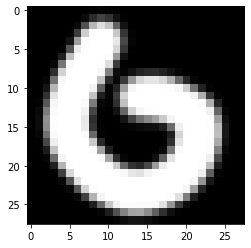

Prediction: 5


In [14]:
img = Image.open('0.png')
re_img = torch.Tensor([[np.asarray(img.convert('L'))]])
plt.imshow(img, cmap='gray', interpolation='none')

output = model(re_img)

plt.show()
print("Prediction:",output.argmax(1, keepdim=True).item())

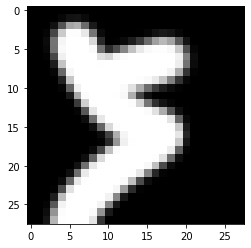

Prediction: 8


In [15]:
img = Image.open('5.png')
re_img = torch.Tensor([[np.asarray(img.convert('L'))]])
plt.imshow(img, cmap='gray', interpolation='none')

output = model(re_img)

plt.show()
print("Prediction:",output.argmax(1, keepdim=True).item())

## 2. Adversarial Attack
### 2.1 FGSM Attack
**FGSM** (Fast Gradient Sign Method) is a classic method to add specifically generated noise to the original data when knowing the inner structure of the model s.t. the generated adversial samples can tempt the model to misktake them for incorrect categories.  
Its main idea can be represented as following equations.

$$ \widetilde{x}=x+η$$

$$η=ε  \cdot{\rm sign}(∇_x J(θ,x,y))$$  
where $η$ is the generated noise, $ε$ is a hyperparameter to control the range of the perturbation, $θ$ is the parameters of the attacked model, $\widetilde{x}$ is the adversial sample generated, $x$ is the input, $y$ is the label, $J(θ,x,y)$ is the loss function used in the attacked model.  
#### 2.1.1 Hyperparameters
The only hyperparameter is $ε$.

In [80]:
# Hyperparameters
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

#### 2.1.2 FGSM Definition
The following blocks define the FGSM function and test the original model on FGSM-generated perturbation samples.
- The FGSM function generates adversial samples (or perturbations) based on original data, $ε$ and $∇_x J(θ,x,y)$.
- FGSM_test applies FGSM attack on the model fed in as inputs and test the model on adversial samples generated.  

Details are given in the annotations.

**Notice:**
- Since we normalize the test data when loading the test dataset, here we clamp the perturbation into $[min,max]$ instead of $[0,1]$.
- In this case, the original $ε$ does not actually represent the range of perturbation. The true range perturbation should relate to both $ε$ and $|max-min|$, i.e. the real $ε_{perturbation}$ used should be $ε\cdot |max-min|$.

In [12]:
# Naive FGSM, used when the range of all input data is [0,1]
def FGSM_naive(input_data, epsilon, data_grad):
    pert = input_data + epsilon * data_grad.sign()
    pert = torch.clamp(pert, 0, 1)
    return pert

# Advanced FGSM, used when the dataset is already normalize in the data preprocessing.
def FGSM_ad(input_data, epsilon, data_grad):
    pert = input_data + epsilon * data_grad.sign()
    pert = torch.clamp(pert, input_data.min(), input_data.max())
    return pert

# Our FGSM, regarding epsilon fed in as a coefficient instead of the true range of perturbation.
universal_max = 1
universal_min = 0
if normalize:
    universal_max = (universal_max - normalize_mean[0]) / normalize_std[0]
    universal_min = (universal_min - normalize_mean[0]) / normalize_std[0]

def FGSM(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) * data_grad.sign()
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

In [82]:
def FGSM_test(model, test_loader, epsilon, FGSM):

    correct = 0
    adv_examples = []

    for data_batch, target_batch in test_loader:    # Batch Processing
        for i in range(data_batch.size()[0]):
            data, target = data_batch[i].unsqueeze(0), target_batch[i].unsqueeze(0)
            data.requires_grad = True
            output = model(data)                                     # Output before FGSM Attack
            fore_pred = output.data.max(1, keepdim=True)[1]
            if fore_pred.item() != target.item(): continue          # Already failed prediction, discard

            loss = loss_func_test(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            pert = FGSM(data, epsilon, data_grad)                    # FGSM Attack

            output = model(pert)
            post_pred = output.max(1, keepdim=True)[1]              # Output after the FGSM Attack
            if post_pred.item() == target.item():
                correct += 1
            else:
                if len(adv_examples) < 5:
                    example = pert.squeeze().detach().cpu().numpy()
                    adv_examples += [(fore_pred.item(), post_pred.item(), example)]
            if (epsilon == 0) and (len(adv_examples) < 5):
                           # Preparation for the following visualization, taking eps=0 into account
                example = pert.squeeze().detach().cpu().numpy()
                adv_examples += [(fore_pred.item(), post_pred.item(), example)]

    final_acc = correct/(float(len(test_loader.dataset)))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.2f}%".format(epsilon, correct, len(test_loader.dataset), final_acc*100.))

    return final_acc, adv_examples

#### 2.1.3 FGSM Attack

In [83]:
accuracies = []
examples = []

for eps in epsilons:
    start = time.time()
    acc, expl = FGSM_test(model, test_loader, eps, FGSM)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000), end="\n\n")

Epsilon: 0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 32367.810249328613 ms

Epsilon: 0.1	Test Accuracy = 8068 / 10000 = 80.68%
Execution Time: 30118.199825286865 ms

Epsilon: 0.2	Test Accuracy = 5555 / 10000 = 55.55%
Execution Time: 30741.259336471558 ms

Epsilon: 0.3	Test Accuracy = 3473 / 10000 = 34.73%
Execution Time: 30897.38392829895 ms

Epsilon: 0.4	Test Accuracy = 1868 / 10000 = 18.68%
Execution Time: 30667.686700820923 ms

Epsilon: 0.5	Test Accuracy = 1257 / 10000 = 12.57%
Execution Time: 30877.414226531982 ms

Epsilon: 0.6	Test Accuracy = 1035 / 10000 = 10.35%
Execution Time: 30743.123292922974 ms



#### 2.1.4 Visualization of Adversial Samples
The following visualization is based on the code given at https://pytorch.org/tutorials/beginner/fgsm_tutorial.html?highlight=fgsm.

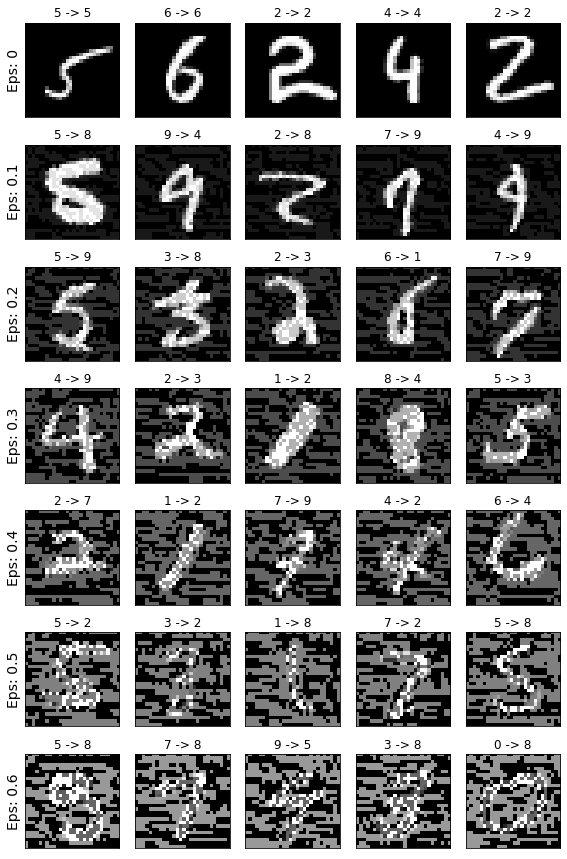

In [84]:
fgsm_acc = accuracies

cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

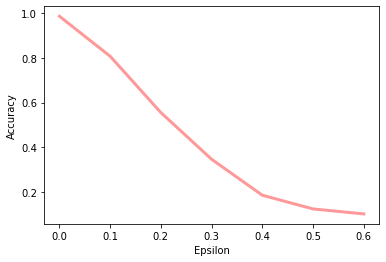

In [85]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(epsilons, accuracies, color='#ff9999', linewidth=3)
#ax1.scatter(test_cnt, test_loss, color='red')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

### 2.2 PGD
**PGD** is so far the most powerful 1-level attack methods. It can be viewed as **i-FGSM** (iteration-FGSM, i.e. using FGSM to attack the model for several rounds) with step $α$ and a random noise initialization in each iteration.  
Also, in each iteration, we need to clamp the generated noise in $[-ε,ε]$.  
The main idea of PGD attack can be represented as following equations.  

$$x^{t+1}=∏_{x+S}(x^t+αsign(∇_x J(θ,x,y))) $$

$$\widetilde{x}=x^{k}$$

where $x^{t}$ indicates the sample generated after $t$ iterations, $k$ is the number of attack iterations, $θ$ is the parameters of the attacked model, $x$ is the original input, $y$ is the label, $J(θ,x,y)$ is the loss function used in the attacked model.  

#### 2.2.1 Hyperparameters
Hyperparameters of PGD attack includes $α$, the step of single-attack (i.e. FGSM attack), $ε$, the control of max perburtation, and $k$, steps, i.e. the number of attack iterations.

In [103]:
# Hyperparameters
steps = 5
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
alphas = np.divide(epsilons, steps)

#### 2.2.2. PGD Definition

In [106]:
def PGD(model, test_loader, k, alpha, epsilon):
    
    def FGSM(input_data, alpha, epsilon, data_grad):
        noise = alpha * (universal_max - universal_min) * data_grad.sign()
        eps = epsilon * (universal_max - universal_min)
        noise = torch.clamp(noise, -eps, eps)
        pert = input_data + noise
        pert = torch.clamp(pert, universal_min, universal_max)
        return pert

    correct = 0
    adv_examples = []

    for data_batch, target_batch in test_loader:    # Batch Processing
        for i in range(data_batch.size()[0]):
            pert, target = data_batch[i].unsqueeze(0), target_batch[i].unsqueeze(0)
            pert.requires_grad = True
            data = pert
            
            output = model(pert)                                        # Output before PGD Attack
            fore_pred = output.data.max(1, keepdim=True)[1]
            if fore_pred.item() != target.item(): continue              # Already failed prediction, discard
            
            noise = torch.zeros(pert.shape).type_as(pert)
            for iteration in range(k):
                pert = pert + torch.Tensor(np.random.uniform(-epsilon,epsilon,pert.shape)).type_as(pert)   # Cannot use "+="
                pert.retain_grad()
                pred = model(pert)
                loss = loss_func_test(pred, target)
                
                model.zero_grad()
                loss.backward(retain_graph=True)
                pert_grad = pert.grad.data
                pert = FGSM(pert, alpha, epsilon, pert_grad)        # The single step of PGD Attack is an FGSM Attack               
                
            output = model(pert)
            post_pred = output.max(1, keepdim=True)[1]              # Output after the FGSM Attack
            if post_pred.item() == target.item():
                correct += 1
            else:
                if len(adv_examples) < 5:
                    example = pert.squeeze().detach().cpu().numpy()
                    adv_examples += [(fore_pred.item(), post_pred.item(), example)]
            if (epsilon == 0 or alpha == 0) and (len(adv_examples) < 5):
                            # Preparation for the following visualization, taking eps=0 into account
                example = pert.squeeze().detach().cpu().numpy()
                adv_examples += [(fore_pred.item(), post_pred.item(), example)]

    final_acc = correct/(float(len(test_loader.dataset)))
    print("Alpha: {}\tTest Accuracy = {} / {} = {:.2f}%".format(alpha, correct, len(test_loader.dataset), final_acc*100.))

    return final_acc, adv_examples

#### 2.2.3 PGD Attack

In [107]:
accuracies = []
examples = []

for i in range(len(epsilons)):
    start = time.time()
    acc, expl = PGD(model, test_loader, steps, alphas[i], epsilons[i])
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 169968.43671798706 ms

Alpha: 0.02	Test Accuracy = 6142 / 10000 = 61.42%
Execution Time: 196183.18367004395 ms

Alpha: 0.04	Test Accuracy = 709 / 10000 = 7.09%
Execution Time: 190864.69531059265 ms

Alpha: 0.06	Test Accuracy = 15 / 10000 = 0.15%
Execution Time: 190521.73972129822 ms

Alpha: 0.08	Test Accuracy = 2 / 10000 = 0.02%
Execution Time: 170399.5554447174 ms

Alpha: 0.1	Test Accuracy = 0 / 10000 = 0.00%
Execution Time: 169491.03808403015 ms

Alpha: 0.12	Test Accuracy = 0 / 10000 = 0.00%
Execution Time: 178464.95723724365 ms



#### 2.2.4 Visualization of Adversial Samples
The following visualization is based on the code given at https://pytorch.org/tutorials/beginner/fgsm_tutorial.html?highlight=fgsm.

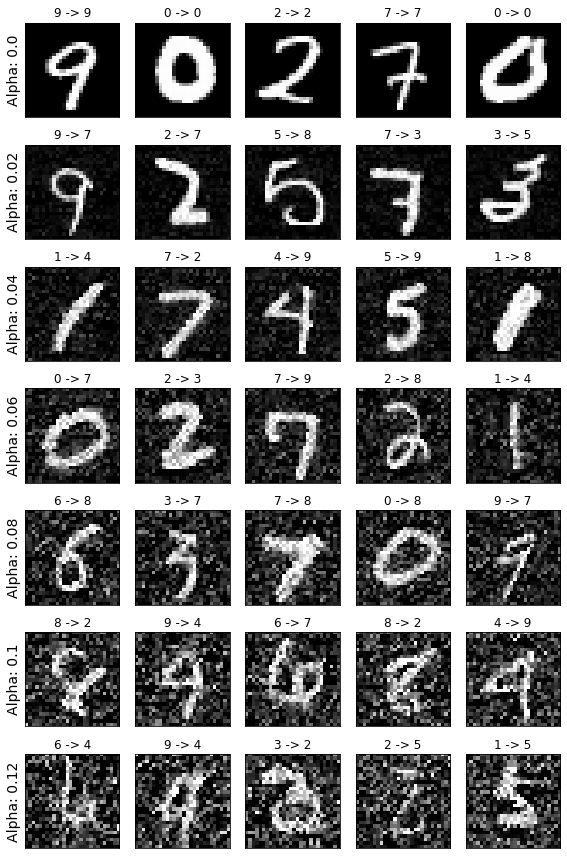

In [108]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Alpha: {}".format(alphas[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

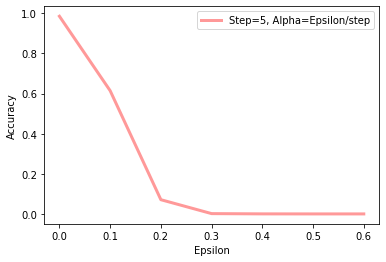

In [109]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(epsilons, accuracies, color='#ff9999',linewidth=3)
#ax1.scatter(test_cnt, test_loss, color='red')
plt.legend(['Step=5, Alpha=Epsilon/step'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

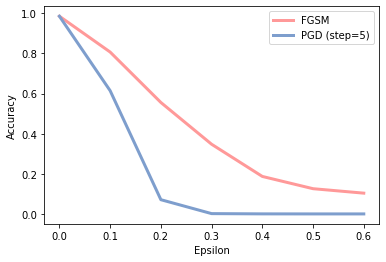

In [110]:
pgd_acc = accuracies

fig = plt.figure()

plt.plot(epsilons, fgsm_acc, color='#ff9999',linewidth=3)
plt.plot(epsilons, pgd_acc, color='#7e9ecd',linewidth=3)
plt.legend(['FGSM','PGD (step=5)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

#### 2.2.5 Different Steps

In [111]:
accuracies = []
examples = []
steps = [2, 5, 8, 10, 20, 40]

for stp in steps:
    start = time.time()
    acc, expl = PGD(model, test_loader, int(stp), 0.15 / stp, 0.15)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.075	Test Accuracy = 4916 / 10000 = 49.16%
Execution Time: 80149.01971817017 ms

Alpha: 0.03	Test Accuracy = 2943 / 10000 = 29.43%
Execution Time: 169589.64657783508 ms

Alpha: 0.01875	Test Accuracy = 2222 / 10000 = 22.22%
Execution Time: 274145.1904773712 ms

Alpha: 0.015	Test Accuracy = 1975 / 10000 = 19.75%
Execution Time: 338922.92404174805 ms

Alpha: 0.0075	Test Accuracy = 1397 / 10000 = 13.97%
Execution Time: 716580.2273750305 ms

Alpha: 0.00375	Test Accuracy = 1051 / 10000 = 10.51%
Execution Time: 1555517.0984268188 ms



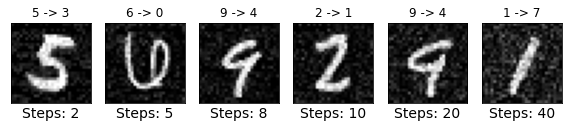

In [122]:
plt.figure(figsize=(8,2))
for i in range(len(steps)):
    plt.subplot(1,len(steps),i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("Steps: {}".format(steps[i]), fontsize=14)
    orig,adv,ex = examples[i][0]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

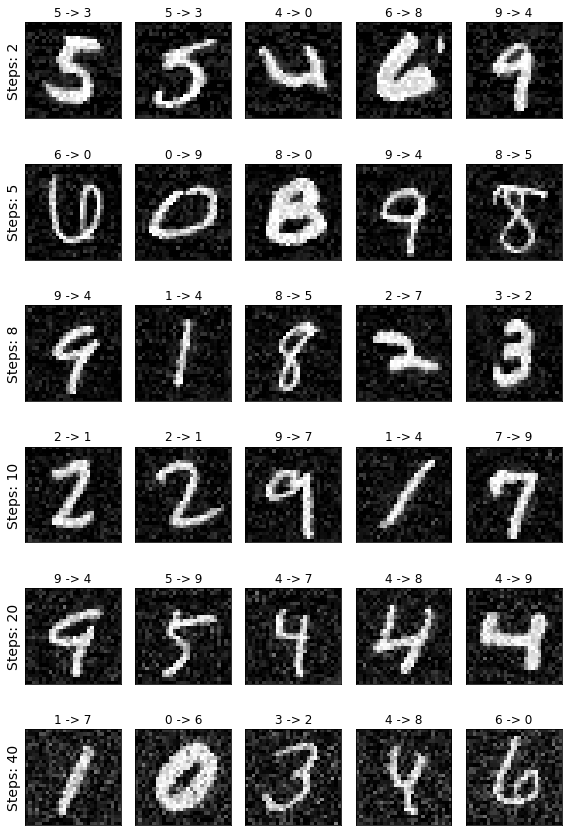

In [112]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(steps)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(steps),len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Steps: {}".format(steps[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

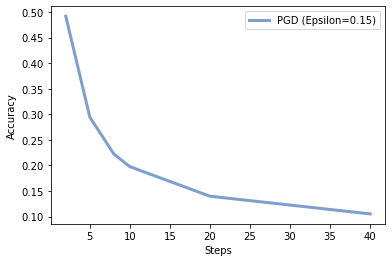

In [120]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(steps, accuracies, color='#7e9ecd',linewidth=3)
plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Steps')
plt.show()

### 2.3 PGD with Carlini-Wagner Loss
It is obvious that an adversial sample generated with a smaller distance to the original data and a larger probability in mistaken category is better.  
Therefore, we can rewrite the form of loss function to further enpower the attack.  
Nevertheless, previous work has already covered this idea, known as **CW**.  \
Moreover, the idea of PGD with CW loss is already given in the original paper proposing PGD.  

#### 2.3.1 Hyperparameters

In [185]:
# Hyperparameters
constant = 1e-4
steps = 5
kappa = 0
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

#### 2.3.2 CW-Loss Definition

In [189]:
def loss_cw(data, pert, pred, target, kappa, constant):
    target_mask = torch.eye(len(pred[0]))[target].float()
    correct_cat = torch.masked_select(pred, target_mask.bool())
    wrong_cat = torch.argmax((1 - target_mask) * pred, dim=1).float()
    f_cw = torch.clamp(-correct_cat + wrong_cat, min=kappa*(universal_max-universal_min))
    loss = nn.MSELoss(reduction='sum')(pert, data) + torch.sum(constant*f_cw)
    
    return loss

In [190]:
def PGD_cw(model, test_loader, k, alpha, epsilon, kappa, constant):
    
    def FGSM(input_data, alpha, epsilon, data_grad):
        noise = alpha * (universal_max - universal_min) * data_grad.sign()
        eps = epsilon * (universal_max - universal_min)
        noise = torch.clamp(noise, -eps, eps)
        pert = input_data + noise
        pert = torch.clamp(pert, universal_min, universal_max)
        return pert

    correct = 0
    adv_examples = []

    for data_batch, target_batch in test_loader:    # Batch Processing
        for i in range(data_batch.size()[0]):
            pert, target = data_batch[i].unsqueeze(0), target_batch[i].unsqueeze(0)
            pert.requires_grad = True
            data = pert
            
            output = model(pert)                                        # Output before PGD Attack
            fore_pred = output.data.max(1, keepdim=True)[1]
            if fore_pred.item() != target.item(): continue              # Already failed prediction, discard
            
            noise = torch.zeros(pert.shape).type_as(pert)
            for iteration in range(k):
                pert = pert + torch.Tensor(np.random.uniform(-epsilon,epsilon,pert.shape)).type_as(pert)   # Cannot use "+="
                pert.retain_grad()
                pred = model(pert)
                loss = loss_cw(data, pert, pred, target, kappa, constant)
                
                model.zero_grad()
                loss.backward(retain_graph=True)
                pert_grad = pert.grad.data
                pert = FGSM(pert, alpha, epsilon, pert_grad)        # The single step of PGD Attack is an FGSM Attack               
                
            output = model(pert)
            post_pred = output.max(1, keepdim=True)[1]              # Output after the FGSM Attack
            if post_pred.item() == target.item():
                correct += 1
                if len(adv_examples) < 5:
                    example = pert.squeeze().detach().cpu().numpy()
                    adv_examples += [(fore_pred.item(), post_pred.item(), example)]
            if (epsilon == 0 or alpha == 0) and (len(adv_examples) < 5):
                            # Preparation for the following visualization, taking eps=0 into account
                example = pert.squeeze().detach().cpu().numpy()
                adv_examples += [(fore_pred.item(), post_pred.item(), example)]

    final_acc = correct/(float(len(test_loader.dataset)))
    print("Alpha: {}\tTest Accuracy = {} / {} = {:.2f}%".format(alpha, correct, len(test_loader.dataset), final_acc*100.))

    return final_acc, adv_examples

#### 2.3.3 CW-Loss PGD Attack

In [188]:
accuracies = []
examples = []
alphas = np.divide(epsilons,steps)

for i in range(len(epsilons)):
    start = time.time()
    acc, expl = PGD_cw(model, test_loader, steps, alphas[i], epsilons[i], kappa, constant)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 177654.29735183716 ms

Alpha: 0.02	Test Accuracy = 9846 / 10000 = 98.46%
Execution Time: 185202.48174667358 ms

Alpha: 0.04	Test Accuracy = 9846 / 10000 = 98.46%
Execution Time: 172865.91053009033 ms

Alpha: 0.06	Test Accuracy = 9838 / 10000 = 98.38%
Execution Time: 179246.1290359497 ms

Alpha: 0.08	Test Accuracy = 9833 / 10000 = 98.33%
Execution Time: 177440.60754776 ms



KeyboardInterrupt: 

#### 2.3.4 Visualization of Adversial Samples
The following visualization is based on the code given at https://pytorch.org/tutorials/beginner/fgsm_tutorial.html?highlight=fgsm.

In [ ]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
cw_acc = accuracies

import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(epsilons, cw_acc, color='#ff9999',linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

In [ ]:
plt.figure(figsize=(8,2))
for i in range(len(kappas)):
    plt.subplot(1,len(kappas),i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("Kappa: {}".format(kappas[i]), fontsize=14)
    orig,adv,ex = examples[i][0]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [191]:
accuracies = []
examples = []
steps = [2, 5, 8, 10, 20, 40]

for stp in steps:
    start = time.time()
    acc, expl = PGD_cw(model, test_loader, int(stp), 0.15 / stp, 0.15, 0, constant)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.075	Test Accuracy = 9663 / 10000 = 96.63%
Execution Time: 76600.55327415466 ms

Alpha: 0.03	Test Accuracy = 9311 / 10000 = 93.11%
Execution Time: 164872.58124351501 ms

Alpha: 0.01875	Test Accuracy = 9168 / 10000 = 91.68%
Execution Time: 263100.2962589264 ms

Alpha: 0.015	Test Accuracy = 9077 / 10000 = 90.77%
Execution Time: 328147.8612422943 ms

Alpha: 0.0075	Test Accuracy = 8766 / 10000 = 87.66%
Execution Time: 697351.7019748688 ms

Alpha: 0.00375	Test Accuracy = 7826 / 10000 = 78.26%
Execution Time: 1654429.5258522034 ms



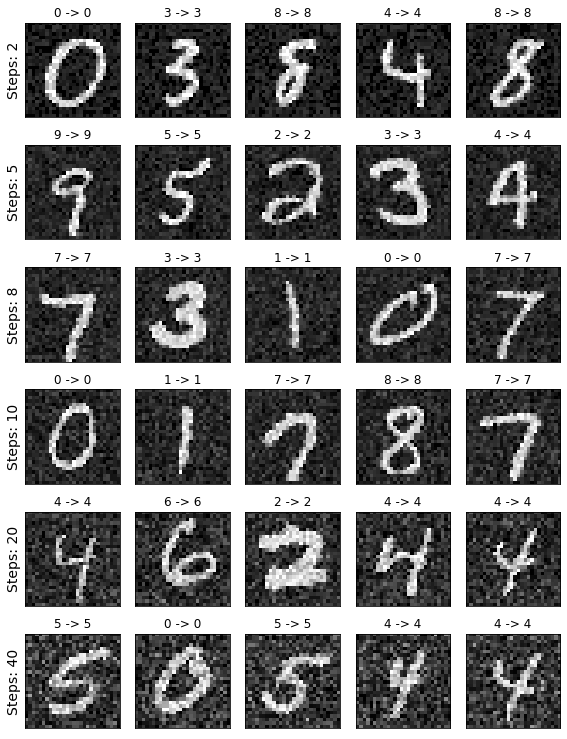

In [192]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(steps)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(steps)+1,len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Steps: {}".format(steps[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

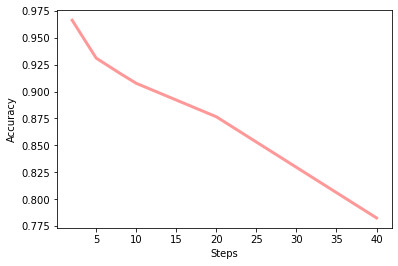

In [193]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(steps, accuracies, color='#ff9999',linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Steps')
plt.show()

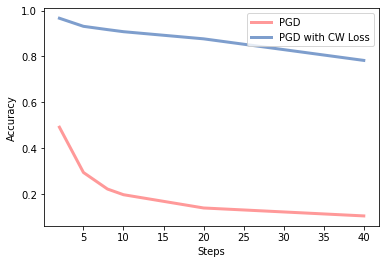

In [194]:
pgdstp_acc = [0.4916, 0.2943, 0.2222, 0.1975, 0.1397, 0.1051]

fig = plt.figure()

plt.plot(steps, pgdstp_acc, color='#ff9999',linewidth=3)
plt.plot(steps, accuracies, color='#7e9ecd',linewidth=3)
plt.legend(['PGD','PGD with CW Loss'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Steps')
plt.show()

In [198]:
accuracies = []
examples = []
constants = [1e-4, 1e-3, 1e-2, 1e-1]

for cons in constants:
    start = time.time()
    acc, expl = PGD_cw(model, test_loader, 10, 0.15 / stp, 0.15, 0, cons)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.00375	Test Accuracy = 9768 / 10000 = 97.68%
Execution Time: 413243.4413433075 ms

Alpha: 0.00375	Test Accuracy = 9783 / 10000 = 97.83%
Execution Time: 425306.1156272888 ms

Alpha: 0.00375	Test Accuracy = 9783 / 10000 = 97.83%
Execution Time: 426794.7292327881 ms



KeyboardInterrupt: 

IndexError: list index out of range

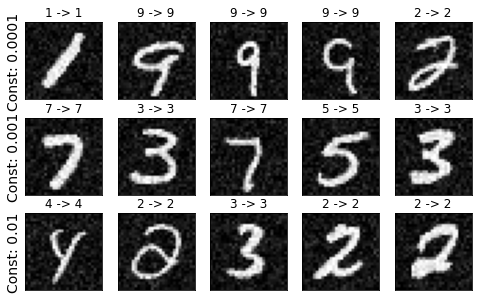

In [199]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(constants)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(7,len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Const: {}".format(constants[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

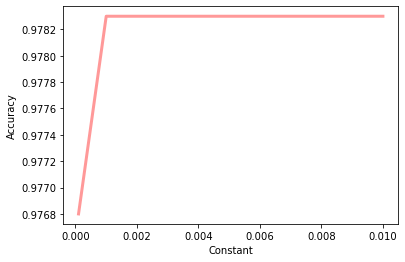

In [201]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot([1e-4,1e-3,1e-2], accuracies, color='#ff9999',linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Constant')
plt.show()

### 2.4 FGM, PGD with Different Functions

In [8]:
epsilons = [0, 0.1, 0.2, 0.3, 0.6, 0.9, 1.2]

In [208]:
def FGSM_exp(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) * torch.exp(data_grad)
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

In [ ]:
def FGSM_mul(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) / data_grad
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

In [ ]:
def FGSM_absexp(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) * torch.exp(torch.abs(data_grad))
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

In [ ]:
def FGSM_leap(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) * (func.leaky_relu(data_grad.sign()) + 1)
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

In [7]:
def stairs(x):
    y = np.multiply(np.array(x>.5, dtype=np.int), 1)
    y = y + np.multiply(np.array(x>.2, dtype=np.int), 0.5)
    y = y + np.multiply(np.array(x>0, dtype=np.int), 0.25)
    y = y + np.multiply(np.array(x<0, dtype=np.int), -0.25)
    y = y + np.multiply(np.array(x<-.2, dtype=np.int),-1)
    return torch.Tensor(y)

def FGSM_stairs(input_data, epsilon, data_grad):
    pert = input_data + epsilon * (universal_max - universal_min) * stairs(data_grad.detach().numpy())
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

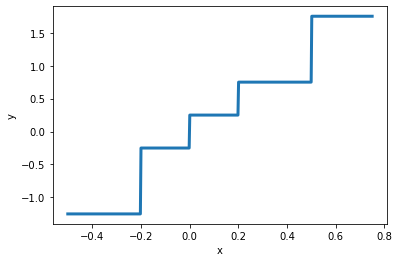

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()

x = np.linspace(-0.5, 0.75, 500)
y = stairs(x)

plt.plot(x, y, linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('y')

plt.xlabel('x')
plt.show()

In [209]:
accuracies = []
examples = []

for eps in epsilons:
    start = time.time()
    acc, expl = FGSM_test(model, test_loader, eps, FGSM_exp)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")
    

Epsilon: 0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 35730.25703430176 ms

Epsilon: 0.1	Test Accuracy = 9555 / 10000 = 95.55%
Execution Time: 37515.71869850159 ms

Epsilon: 0.2	Test Accuracy = 7662 / 10000 = 76.62%
Execution Time: 41103.19519042969 ms

Epsilon: 0.3	Test Accuracy = 5906 / 10000 = 59.06%
Execution Time: 41591.76683425903 ms

Epsilon: 0.6	Test Accuracy = 4093 / 10000 = 40.93%
Execution Time: 43089.810371398926 ms

Epsilon: 0.9	Test Accuracy = 976 / 10000 = 9.76%
Execution Time: 45319.76890563965 ms

Epsilon: 1.2	Test Accuracy = 976 / 10000 = 9.76%
Execution Time: 44937.615394592285 ms



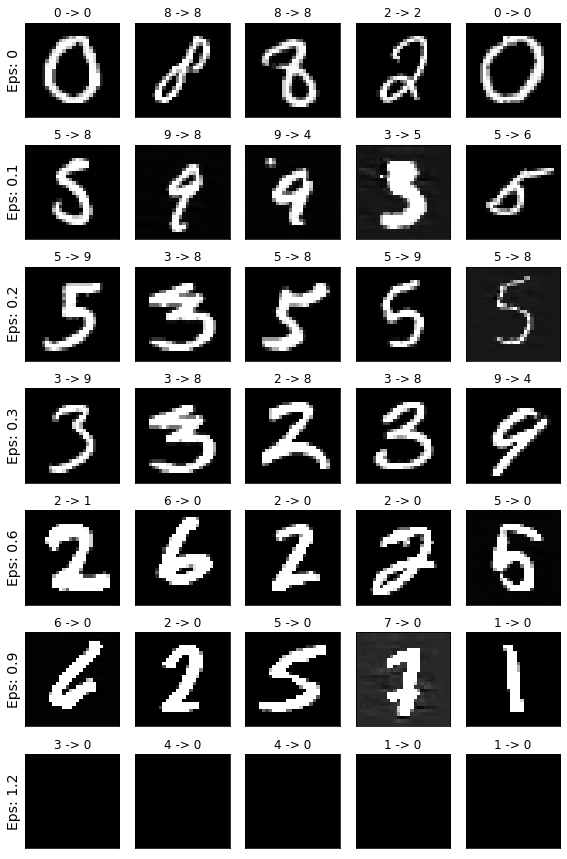

In [210]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

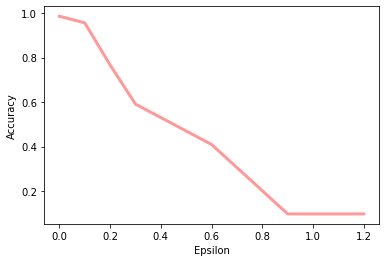

In [211]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(epsilons, accuracies, color='#ff9999',linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

In [235]:
accuracies = []
examples = []

epsilons = [0, 0.1, 0.3,0.6, 0.9, 1.2]

for eps in epsilons:
    start = time.time()
    acc, expl = FGSM_test(model, test_loader, eps, FGSM_stairs)
    accuracies += [acc]
    examples += [expl]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Epsilon: 0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 37247.51830101013 ms

Epsilon: 0.1	Test Accuracy = 9549 / 10000 = 95.49%
Execution Time: 37427.33407020569 ms

Epsilon: 0.3	Test Accuracy = 8666 / 10000 = 86.66%
Execution Time: 40164.43943977356 ms

Epsilon: 0.6	Test Accuracy = 6828 / 10000 = 68.28%
Execution Time: 34077.87728309631 ms

Epsilon: 0.9	Test Accuracy = 4990 / 10000 = 49.90%
Execution Time: 33508.46219062805 ms

Epsilon: 1.2	Test Accuracy = 3481 / 10000 = 34.81%
Execution Time: 33896.77882194519 ms



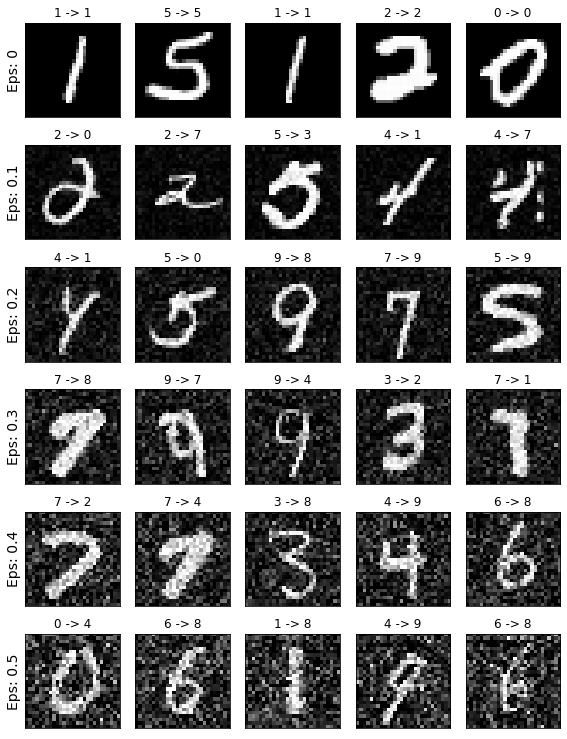

In [31]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(7,len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
steps = 10
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
alphas = np.divide(epsilons, steps)

In [14]:
def PGD_single(input_data, alpha, epsilon, data_grad):
    noise = alpha * (universal_max - universal_min) * (stairs(data_grad))
    eps = epsilon * (universal_max - universal_min)
    noise = torch.clamp(noise, -eps, eps)
    pert = input_data + noise
    pert = torch.clamp(pert, universal_min, universal_max)
    return pert

def PGD(model, test_loader, k, alpha, epsilon):

    correct = 0
    adv_examples = []
    ori_examples = []

    for data_batch, target_batch in test_loader:    # Batch Processing
        for i in range(data_batch.size()[0]):
            pert, target = data_batch[i].unsqueeze(0), target_batch[i].unsqueeze(0)
            pert.requires_grad = True
            data = pert
            
            output = model(pert)                                        # Output before PGD Attack
            fore_pred = output.data.max(1, keepdim=True)[1]
            if fore_pred.item() != target.item(): continue              # Already failed prediction, discard
            
            noise = torch.zeros(pert.shape).type_as(pert)
            for iteration in range(k):
                pert = pert + torch.Tensor(np.random.uniform(-epsilon,epsilon,pert.shape)).type_as(pert)   # Cannot use "+="
                pert.retain_grad()
                pred = model(pert)
                loss = loss_func_test(pred, target)
                
                model.zero_grad()
                loss.backward(retain_graph=True)
                pert_grad = pert.grad.data
                pert = PGD_single(pert, alpha, epsilon, pert_grad)        # The single step of PGD Attack is an FGSM Attack               
                
            output = model(pert)
            post_pred = output.max(1, keepdim=True)[1]              # Output after the FGSM Attack
            if post_pred.item() == target.item():
                correct += 1
            else:
                if len(adv_examples) < 5:
                    example = pert.squeeze().detach().cpu().numpy()
                    adv_examples += [(fore_pred.item(), post_pred.item(), example)]
            if (epsilon == 0 or alpha == 0) and (len(adv_examples) < 5):
                            # Preparation for the following visualization, taking eps=0 into account
                example = pert.squeeze().detach().cpu().numpy()
                adv_examples += [(fore_pred.item(), post_pred.item(), example)]
                example = data.squeeze().detach().cpu().numpy()
                ori_examples += [example]

    final_acc = correct/(float(len(test_loader.dataset)))
    print("Alpha: {}\tTest Accuracy = {} / {} = {:.2f}%".format(alpha, correct, len(test_loader.dataset), final_acc*100.))

    return final_acc, adv_examples, ori_examples

In [15]:
accuracies = []
examples = []
original = []

for i in range(len(epsilons)):
    start = time.time()
    acc, expl, orig = PGD(model, test_loader, steps, alphas[i], epsilons[i])
    accuracies += [acc]
    examples += [expl]
    original += [orig]
    end = time.time()
    print("Execution Time: %s ms" % ((end-start)*1000),end="\n\n")

Alpha: 0.0	Test Accuracy = 9853 / 10000 = 98.53%
Execution Time: 358992.27261543274 ms

Alpha: 0.01	Test Accuracy = 9388 / 10000 = 93.88%
Execution Time: 291789.3648147583 ms

Alpha: 0.02	Test Accuracy = 8412 / 10000 = 84.12%
Execution Time: 298837.4264240265 ms

Alpha: 0.03	Test Accuracy = 6408 / 10000 = 64.08%
Execution Time: 288760.0874900818 ms

Alpha: 0.04	Test Accuracy = 3237 / 10000 = 32.37%
Execution Time: 299623.4874725342 ms

Alpha: 0.05	Test Accuracy = 946 / 10000 = 9.46%
Execution Time: 301019.58107948303 ms



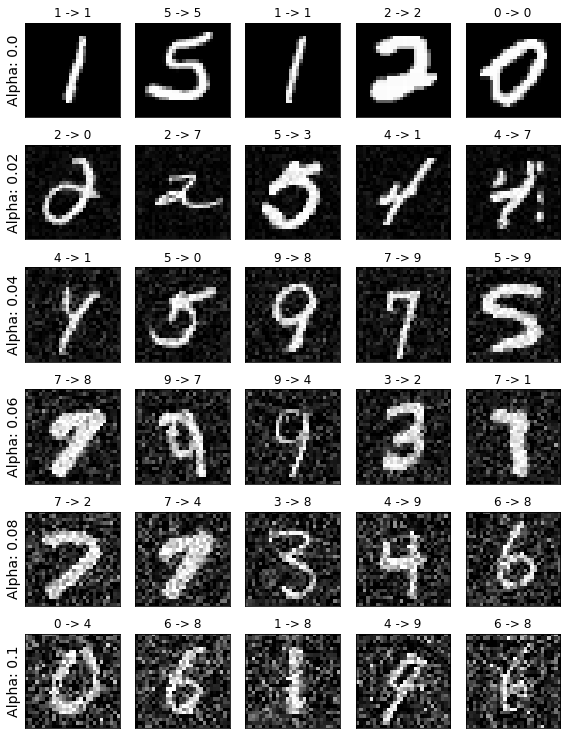

In [34]:
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(7,len(examples[i]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Alpha: {}".format(alphas[i]*2), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        #plt.imshow(original[i][j], cmap="gray")
plt.tight_layout()
plt.show()

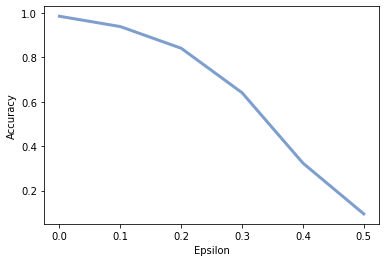

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(epsilons, accuracies, color='#7e9ecd',linewidth=3)
#plt.legend(['PGD (Epsilon=0.15)'], loc='upper right')
plt.ylabel('Accuracy')

plt.xlabel('Epsilon')
plt.show()

## 3. Adversarial Defence

In [ ]:
class Defence(CNN):
    def __init__(self):
        super(Defence,self).__init__()

In [ ]:
defence_k = 3
defence_epsilon = 0.05
defence_learning_rate = 0.005
defence_epochs = 3
defence_model = Defence_CNN()
defence_criterion = F.nll_loss
defence_optimizer = optim.Adam(defence_model.parameters(),lr=defence_learning_rate)
defence_iter_optimizer = optim.Adam(defence_model.parameters(),lr=0.1*defence_learning_rate)
defence_scheduler = StepLR(defence_optimizer,step_size=50,gamma=0.8)
defence_iter_scheduler = StepLR(defence_iter_optimizer,step_size=50,gamma=0.8)
defence_loss_record = list()
defence_accuracy_record = list()

In [ ]:
def defence_train(model,train_data,k,epsilon,epoch):
    model.train()
    correct=0
    for batch,(data,target) in enumerate(train_data):
        data.requires_grad = True
        for i in range(k-1):
            data.retain_grad()
            defence_iter_optimizer.zero_grad()
            model.zero_grad()
            data_temp = data + torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            result = model(data_temp)
            defence_train_loss = defence_criterion(result,target)
            defence_train_loss.backward(retain_graph=True)
            data_grad = data.grad.data
            data = FGSM(data_temp,epsilon,data_grad)
            defence_iter_optimizer.step()
        data_temp = data + torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
        defence_optimizer.zero_grad()
        result = model(data_temp)
        defence_train_loss = defence_criterion(result,target)
        defence_train_loss.backward(retain_graph=True)
        pred=result.argmax(dim=1,keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).sum().item()
        correct += accuracy
        defence_loss_record.append(defence_train_loss.item())
        defence_accuracy_record.append(accuracy / len(data))
        defence_optimizer.step()
        if(batch%10 == 0):
            print("Denfence Train Epoch{} : [ {}/{} ({:.0f}%) ]\nLoss:{:.6f}\tAccuracy: {}/{} ({:.2f}%)".format(
                epoch+1,batch*len(data),len(train_data.dataset),
                100.*batch*len(data)/len(train_data.dataset),defence_train_loss.item(),
                correct,10*len(data),100.*correct/(10*len(data))))
            correct = 0

In [ ]:
def defence_test(model,test_data,k,epsilon):
    model.eval()
    loss = 0
    correct = 0
    for batch,(data,target) in enumerate(test_data):
        data.requires_grad = True
        for i in range(k-1):
            data.retain_grad()
            data_temp = data + torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            model.zero_grad()
            result = model(data_temp)
            defence_test_loss = defence_criterion(result,target)
            defence_test_loss.backward(retain_graph=True)
            data_grad = data.grad.data
            data = FGSM(data_temp,epsilon,data_grad)
        with torch.no_grad():
            data_temp = data+torch.Tensor(np.random.uniform(-epsilon,epsilon,data.shape))
            result = model(data)
            defence_test_loss = defence_criterion(result,target)
            pred = result.argmax(dim=1,keepdim=True)
            accuracy = pred.eq(target.view_as(pred)).sum().item()
            correct += accuracy
            loss += defence_test_loss.item()
        loss /= len(test_data.dataset)
    print("Test Set: Average Loss:{:.6f} Accuracy:{}/{}({:.2f}%)".format(
        loss,correct,
        len(test_data.dataset),
        100.*correct/len(test_data.dataset)))

In [ ]:
for epoch in range(defence_epochs):
    defence_train(defence_model,train_data,defence_k,defence_epsilon,epoch)
    defence_test(defence_model,test_data,defence_k,defence_epsilon)
    defence_iter_scheduler.step()
    defence_scheduler.step()

## 4. License
The codes above had referrences to following sources:  
1. https://zhuanlan.zhihu.com/p/137571225 **[Section 1]**  
2. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html?highlight=fgsm **[Section 2.1]**  
3. https://blog.csdn.net/weixin_41712499/article/details/110878322 **[Section 2.1+2.2]**  
4. https://www.cnblogs.com/tangweijqxx/p/10617752.html **[Section 2.2]**  
5. https://arxiv.org/pdf/1607.02533v4.pdf **[Section 2.2]**
6. https://www.cnblogs.com/tangweijqxx/p/10627360.html **[Section 2.3]**  
7. https://arxiv.org/pdf/1706.06083.pdf (original paper of PGD) **[Section 2.3]**  
8. https://arxiv.org/pdf/1608.04644.pdf (original paper of CW) **[Section 2.3]**  
9. https://arxiv.org/pdf/1412.6572v2.pdf (original paper of FGSM) **[Section 2.4]**